In [2]:
# .libPaths("~/tmp/bi-prs/")      # Modify lib to whatever necessary
library(moments)
library(ggplot2)
library(cowplot)
library(vtable)
library(corrplot)
library(e1071)                  # masks vtable's moments

options(width=160, repr.plot.width=11, repr.plot.height=8)              # Text line width, plot size

# Cvičení 2: Základní popisné statistiky a vizualizace dat

**Obsah cvičení:**
- příprava dat
- popisné výběrové statistiky (míry polohy, rozptýlení, šikmosti a špičatosti)
- vyobrazení v histogramu, boxplotu/violin grafu, scatter plot
- detekce outlierů
- QQ plot a jeho interpretace
- ridgeline plot nebo KDE s gaussovkou
- korelační analýza

## Iris dataset

V tomto cvičení se budeme zabývat **Iris flower datasetem** [(wiki)](https://en.wikipedia.org/wiki/Iris_flower_data_set).<br/> Ten obsahuje údaje o 150 zástupcích kosatců, a to:
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/440px-Iris_versicolor_3.jpg' width='250' style="float:right;"/>

- druh kosatce (I. setosa, I. virginica, I. versicolor)
- petal length
- petal width
- sepal length
- sepal width

    
*Petals* jsou vnitřní korunní lístky, *sepals* vnější.

### Načtení dat, úvodní prohlídka

Diskutujte nad následujícími řádky:

In [3]:
data(iris)
head(iris, 4)
tail(iris, 4)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species
1 5.1          3.5         1.4          0.2         setosa 
2 4.9          3.0         1.4          0.2         setosa 
3 4.7          3.2         1.3          0.2         setosa 
4 4.6          3.1         1.5          0.2         setosa

Sepal.Length Sepal.Width Petal.Length Petal.Width Species  
147 6.3          2.5         5.0          1.9         virginica
148 6.5          3.0         5.2          2.0         virginica
149 6.2          3.4         5.4          2.3         virginica
150 5.9          3.0         5.1          1.8         virginica

Vykreslíme navíc scatter plot, též bodový graf. Podíváme se, jak si stojí data ve dvojicích znaků. Interpretujte výsledky!

<font color="blue">**Nyní je čas udělat úkoly 1 a 2 v druhém notebooku**</font>

---

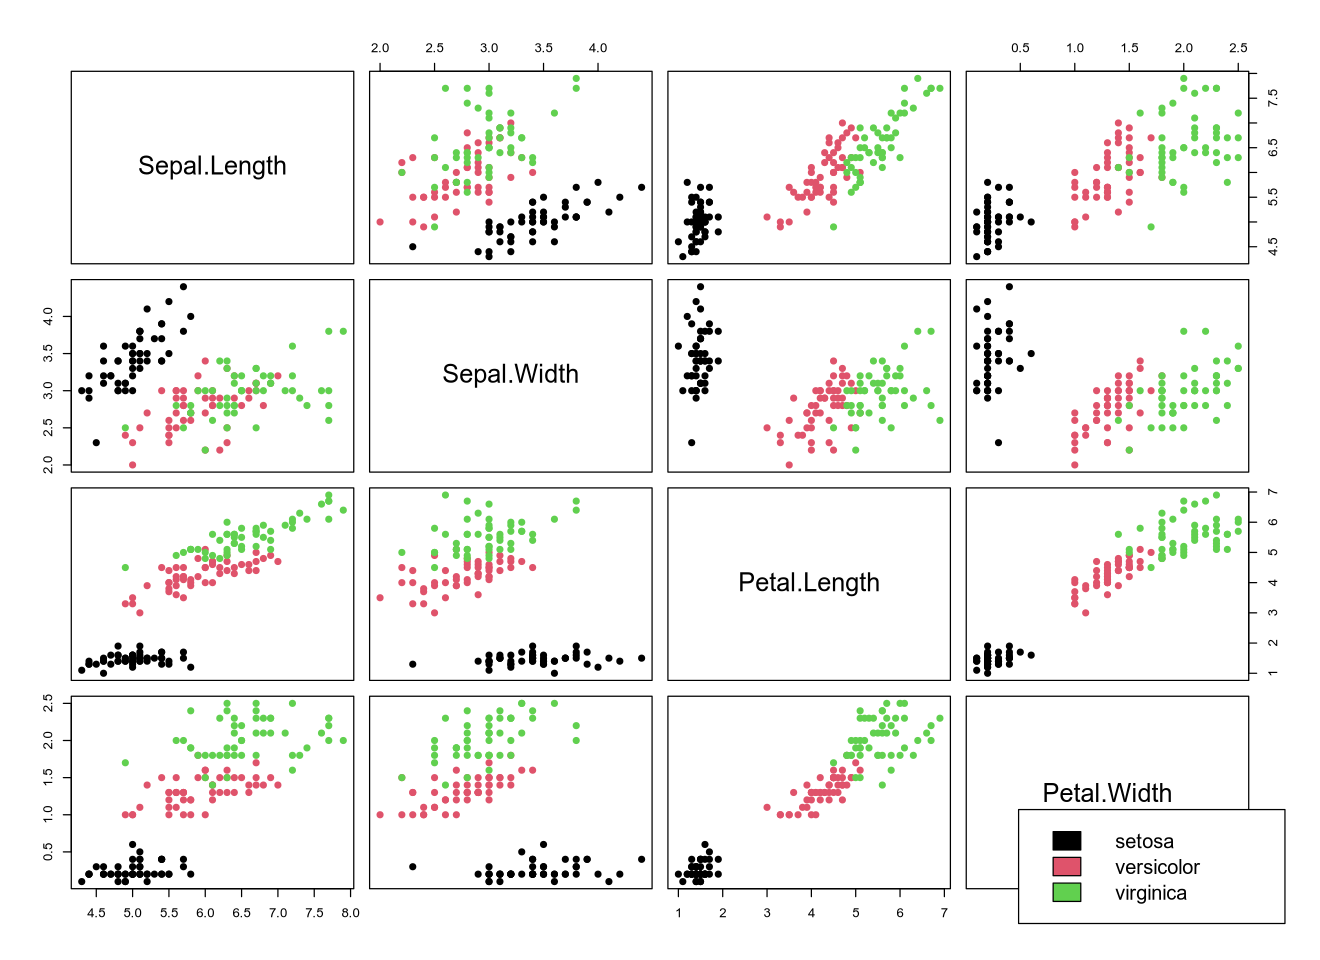

In [4]:
pairs(iris[,1:4], col=iris$Species, pch=19)
par(xpd = TRUE)
legend("bottomright", bty="o", y.intersp=.7, fill = unique(iris$Species), 
       legend = c(levels(iris$Species)))

<font color="blue">**Nyní je čas udělat úkol 3 v druhém notebooku**</font>

---

### Základní popisné statistiky

Interpretujte následující buňky a rozdíl mezi nimi. Za prvé:

In [2]:
summary(iris)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

...a za druhé:

In [9]:
irisVer <- subset(iris, Species=="versicolor", select=-Species)
irisVir <- subset(iris, Species=="virginica", select=-Species)
irisSet <- subset(iris, Species=="setosa", select=-Species)

In [10]:
summary(irisVer)

  Sepal.Length    Sepal.Width     Petal.Length   Petal.Width   
 Min.   :4.900   Min.   :2.000   Min.   :3.00   Min.   :1.000  
 1st Qu.:5.600   1st Qu.:2.525   1st Qu.:4.00   1st Qu.:1.200  
 Median :5.900   Median :2.800   Median :4.35   Median :1.300  
 Mean   :5.936   Mean   :2.770   Mean   :4.26   Mean   :1.326  
 3rd Qu.:6.300   3rd Qu.:3.000   3rd Qu.:4.60   3rd Qu.:1.500  
 Max.   :7.000   Max.   :3.400   Max.   :5.10   Max.   :1.800  

In [11]:
summary(irisVir)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.900   Min.   :2.200   Min.   :4.500   Min.   :1.400  
 1st Qu.:6.225   1st Qu.:2.800   1st Qu.:5.100   1st Qu.:1.800  
 Median :6.500   Median :3.000   Median :5.550   Median :2.000  
 Mean   :6.588   Mean   :2.974   Mean   :5.552   Mean   :2.026  
 3rd Qu.:6.900   3rd Qu.:3.175   3rd Qu.:5.875   3rd Qu.:2.300  
 Max.   :7.900   Max.   :3.800   Max.   :6.900   Max.   :2.500  

In [12]:
summary(irisSet)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.300   Min.   :1.000   Min.   :0.100  
 1st Qu.:4.800   1st Qu.:3.200   1st Qu.:1.400   1st Qu.:0.200  
 Median :5.000   Median :3.400   Median :1.500   Median :0.200  
 Mean   :5.006   Mean   :3.428   Mean   :1.462   Mean   :0.246  
 3rd Qu.:5.200   3rd Qu.:3.675   3rd Qu.:1.575   3rd Qu.:0.300  
 Max.   :5.800   Max.   :4.400   Max.   :1.900   Max.   :0.600  

...a za třetí, s využitím `vtable`:

In [3]:
# sumtable from vtable
summ <- c('notNA(x)', 'mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 
          'median(x)', 'pctile(x)[75]', 'max(x)', 'IQR(x)',
          'skewness(x)', 'kurtosis(x)-3')
sumtable(iris, out="return", summ=summ, group="Species", group.long=T)

Warning message in sumtable(iris, out = "return", summ = summ, group = "Species", :
“Factor variables ignore custom summ options. Cols 1 and 2 are count and percentage.
Beware combining factors with a custom summ unless factor.numeric = TRUE.”


Variable            NotNA Mean Sd   Min Pctile[25] Median Pctile[75] Max IQR  Skewness Kurtosis-3
1  Species: setosa                                                                                  
2  Sepal.Length        50    5    0.35 4.3 4.8        5      5.2        5.8 0.4  0.11     -3.5      
3  Sepal.Width         50    3.4  0.38 2.3 3.2        3.4    3.7        4.4 0.48 0.039    -2.4      
4  Petal.Length        50    1.5  0.17 1   1.4        1.5    1.6        1.9 0.18 0.1      -2.3      
5  Petal.Width         50    0.25 0.11 0.1 0.2        0.2    0.3        0.6 0.1  1.2      -1.7      
6                                                                                                   
7  Species: versicolor                                                                              
8  Sepal.Length        50    5.9  0.52 4.9 5.6        5.9    6.3        7   0.7  0.099    -3.7      
9  Sepal.Width         50    2.8  0.31 2   2.5        2.8    3          3.4 0.48 -0.34    -3.5      
10 Petal.Length        50    4.3  0.47 3   4          4.3    4.6        5.1 0.6  -0.57    -3.2      
11 Petal.Width         50    1.3  0.2  1   1.2        1.3    1.5        1.8 0.3  -0.029   -3.6      
12                                                                                                  
13 Species: virginica                                                                               
14 Sepal.Length        50    6.6  0.64 4.9 6.2        6.5    6.9        7.9 0.67 0.11     -3.2      
15 Sepal.Width         50    3    0.32 2.2 2.8        3      3.2        3.8 0.38 0.34     -2.6      
16 Petal.Length        50    5.6  0.55 4.5 5.1        5.5    5.9        6.9 0.78 0.52     -3.4      
17 Petal.Width         50    2    0.27 1.4 1.8        2      2.3        2.5 0.5  -0.12    -3.8

<font color="blue">**Nyní je čas udělat úkoly 4.a - 4.c v druhém notebooku**</font>

---

### Provotní odhad rozdělení - histogram

Můžeme použít standardní příkazy na obrázky, avšak ty jsou poměrně strohé. Značnou oblibu má ale balík `ggplot2`. Nejjednodušší způsob, jak udělat více subplotů, je pomocí balíku `cowplot`.

Prodiskutujte dosažené výsledky a zkuste nahradit `p1` za zakomentovaný.

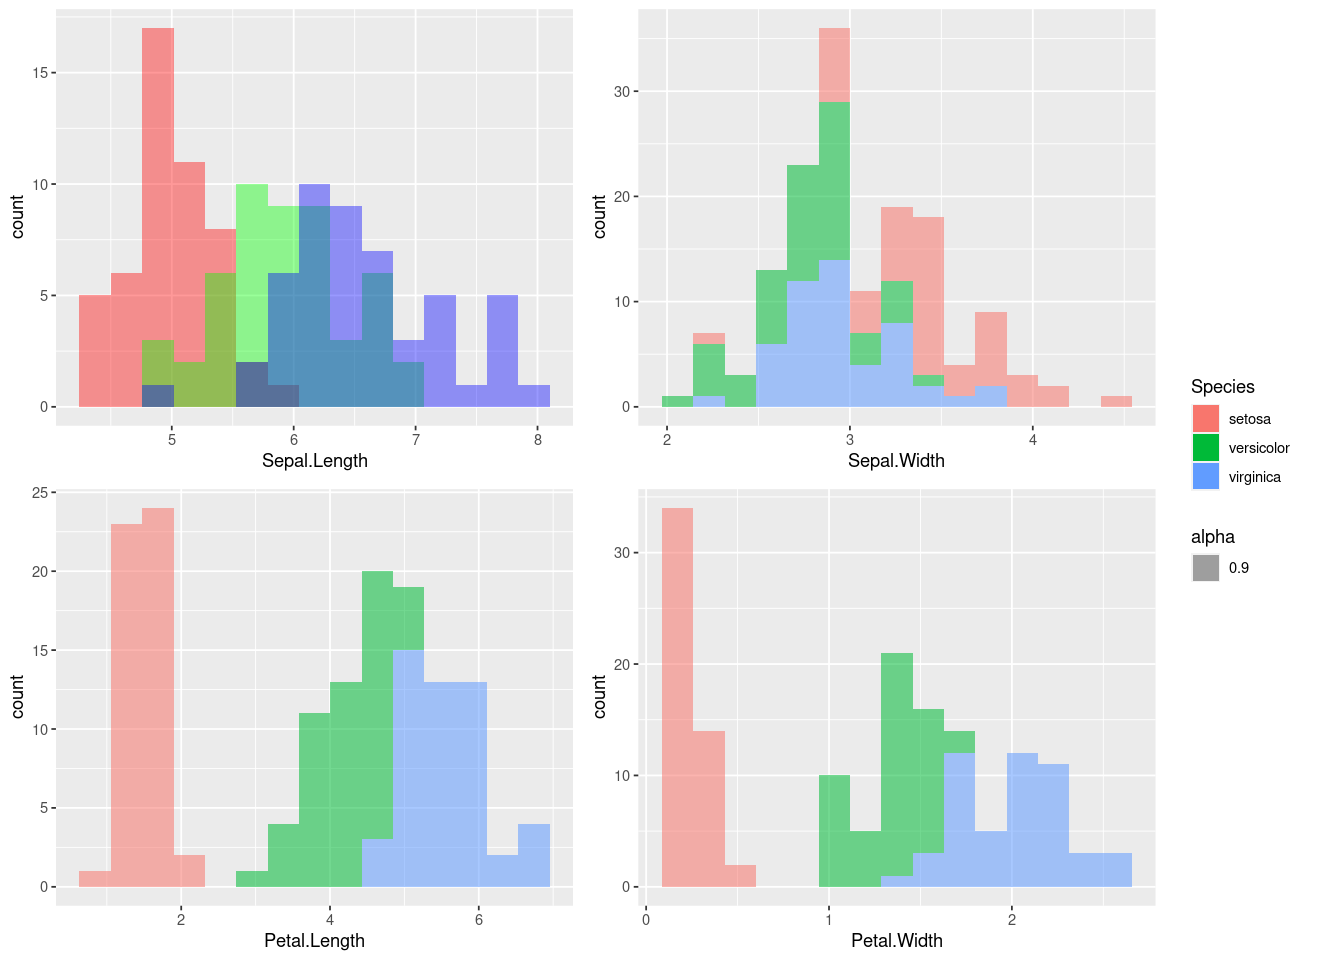

In [10]:
p1 <- ggplot(iris, aes(x=Sepal.Length)) +
        geom_histogram(data=subset(iris, Species=='setosa'), fill='red', bins=15, alpha=.4) +
        geom_histogram(data=subset(iris, Species=='versicolor'), fill='green', bins=15, alpha=.4) +
        geom_histogram(data=subset(iris, Species=='virginica'), fill='blue', bins=15, alpha=.4)
# p1 <- ggplot(iris, aes(x=Sepal.Length, fill=Species, alpha=.3)) +
#         geom_histogram(bins=15)
p2 <- ggplot(iris, aes(x=Sepal.Width, fill=Species, alpha=.3)) +
        geom_histogram(bins=15)
p3 <- ggplot(iris, aes(x=Petal.Length, fill=Species, alpha=.7)) +
        geom_histogram(bins=15)
p4 <- ggplot(iris, aes(x=Petal.Width, fill=Species, alpha=.9)) +
        geom_histogram(bins=15)
pg <- plot_grid(p1 + theme(legend.position="none"), 
                p2 + theme(legend.position="none"), 
                p3 + theme(legend.position="none"), 
                p4 + theme(legend.position="none"),
                nrow=2)
legend <- get_legend(
    p4 + theme()
)
plot_grid(pg, legend, rel_widths = c(3, .4))

<font color="blue">**Nyní je čas udělat úkol 5.a v druhém notebooku**</font>

---

### Prvotní odhad rozdělení - boxplot

Histogramy jsou velmi užitečnými pomocníky, ale občas potřebujeme trochu jednodušší graf. Např. v situaci, kdy bychom v hodinové časové řadě chtěli vykreslit rozdělení predikcí po každých 24h. Vhodným grafem potom bývá boxplot, ve kterém najdeme:
- medián (občas průměr)
- horní a dolní kvartil (ohraničují krabičku)
- whiskery - vousy. Jejich délka je různá, najděte v nápovědě, jak je to v `geom_boxlplot()`!
- odlehlé a extrémní hodnoty

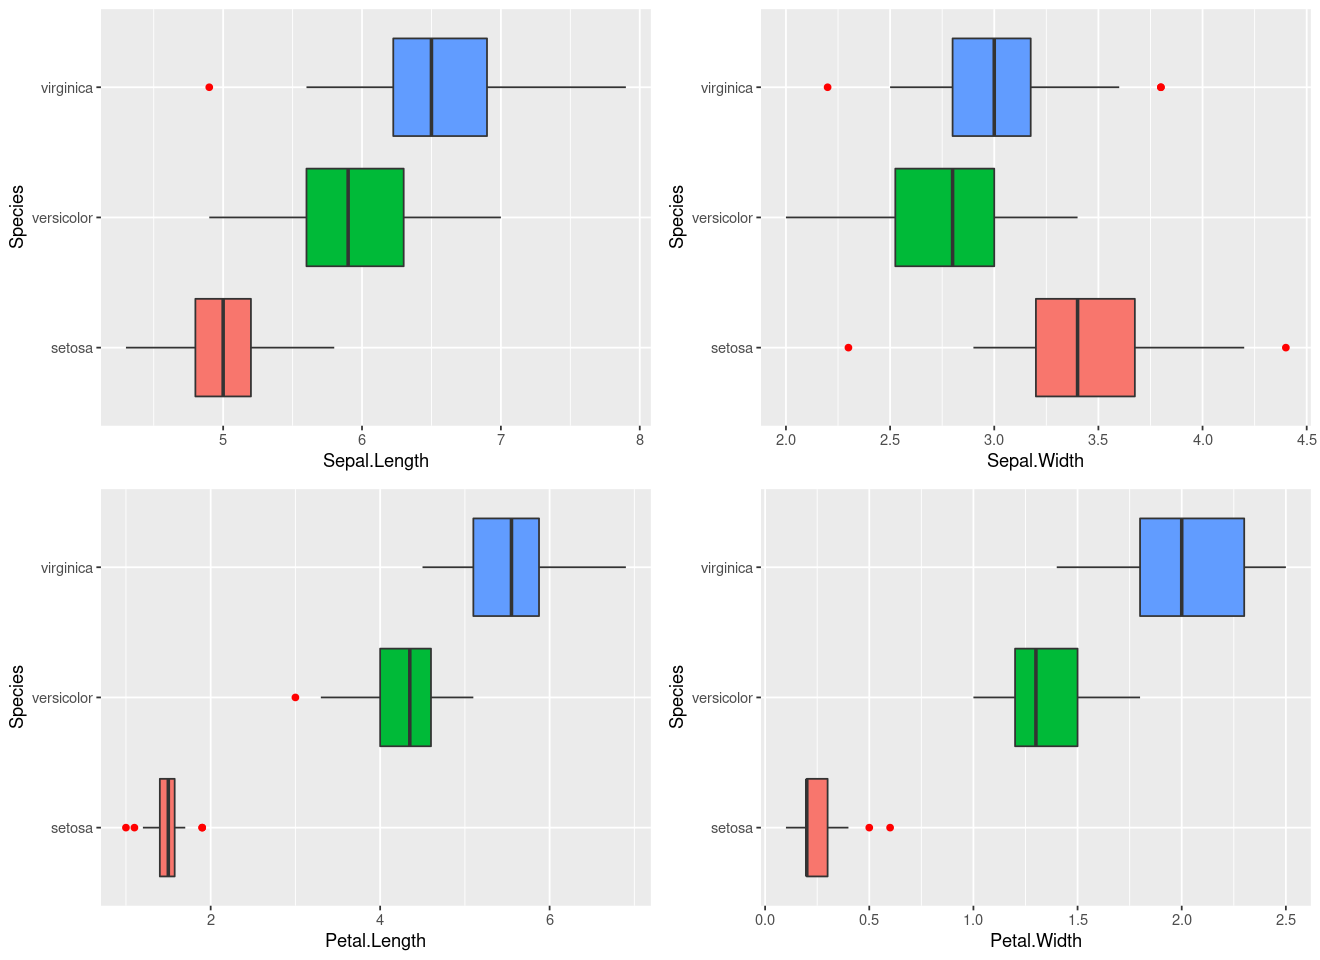

In [11]:
p1 <- ggplot(iris, aes(x=Sepal.Length, y=Species, fill=Species)) +
        geom_boxplot(outlier.color="red", show.legend=F)
p2 <- ggplot(iris, aes(x=Sepal.Width, y=Species, fill=Species)) +
        geom_boxplot(outlier.color="red", show.legend=F)
p3 <- ggplot(iris, aes(x=Petal.Length, y=Species, fill=Species)) +
        geom_boxplot(outlier.color="red", show.legend=F)
p4 <- ggplot(iris, aes(x=Petal.Width, y=Species, fill=Species)) +
        geom_boxplot(outlier.color="red", show.legend=F)
plot_grid(p1, p2, p3, p4, nrow=2)

<font color="blue">**Nyní je čas udělat úkol 5.b v druhém notebooku**</font>

---

### Prvotní odhad rozdělení - violin plot

Violin plot (houslový graf) je podobný boxplotu, akorát namísto krabičky s vousy vykresluje zdcadlený KDE graf. Důvod zrcadlení je pouze estetický. Díky KDE dává o něco více informace, než boxplot, avšak ne vždy je vhodný. Např. ve výše zmíněných časových řadách by jeho vykreslení každých 24h grafu spíše ublížilo.

In [12]:
p1 <- ggplot(iris, aes(x=Species, y=Sepal.Length, fill=Species)) +
        geom_violin(show.legend=F)
p2 <- ggplot(iris, aes(x=Species, y=Sepal.Width, fill=Species)) +
        geom_violin(show.legend=F)
p3 <- ggplot(iris, aes(x=Species, y=Petal.Length, fill=Species)) +
        geom_violin(show.legend=F)
p4 <- ggplot(iris, aes(x=Species, y=Petal.Width, fill=Species)) +
        geom_violin(show.legend=F)
plot_grid(p1, p2, p3, p4, nrow=2)

<font color="blue">**Nyní je čas udělat úkol 5.c v druhém notebooku**</font>

---

### Prvotní odhad rozdělení - Q-Q plot

Q-Q plot, česky též kvantilový graf, vykresluje polohy výběrových kvantilů (z dat) versus polohy kvantilů vybraného teoretického rozdělení (např. normálního). Pokud by výběrové kvantily odpovídaly danému rozdělení, pak by ležely na přímce reprezentující právě toto rozdělení. Více zaznělo na přednášce.

In [13]:
p1 <- ggplot(iris, aes(sample=Sepal.Length, col=Species)) +
        stat_qq(distribution=qnorm, show.legend=T) +
        stat_qq_line(distribution=qnorm, show.legend=F)
p2 <- ggplot(iris, aes(sample=Sepal.Width, col=Species)) +
        stat_qq(distribution=qnorm, show.legend=F) +
        stat_qq_line(distribution=qnorm, show.legend=F)
p3 <- ggplot(iris, aes(sample=Petal.Length, col=Species)) +
        stat_qq(distribution=qnorm, show.legend=T) +
        stat_qq_line(distribution=qnorm, show.legend=F)
p4 <- ggplot(iris, aes(sample=Petal.Width, col=Species)) +
        stat_qq(distribution=qnorm, show.legend=F) +
        stat_qq_line(distribution=qnorm, show.legend=F)
plot_grid(p1, p2, p3, p4, nrow=2)

### Prvotní odhad rozdělení - `GGally`, test normality + výběrový korelační koeficient

`GGally` je balík, pomocí kterého lze velmi pohodlně vykreslit různé grafy a sumarizační statistiky datového souboru. To je výhodné zejm. pro menší množství proměnných v datech.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



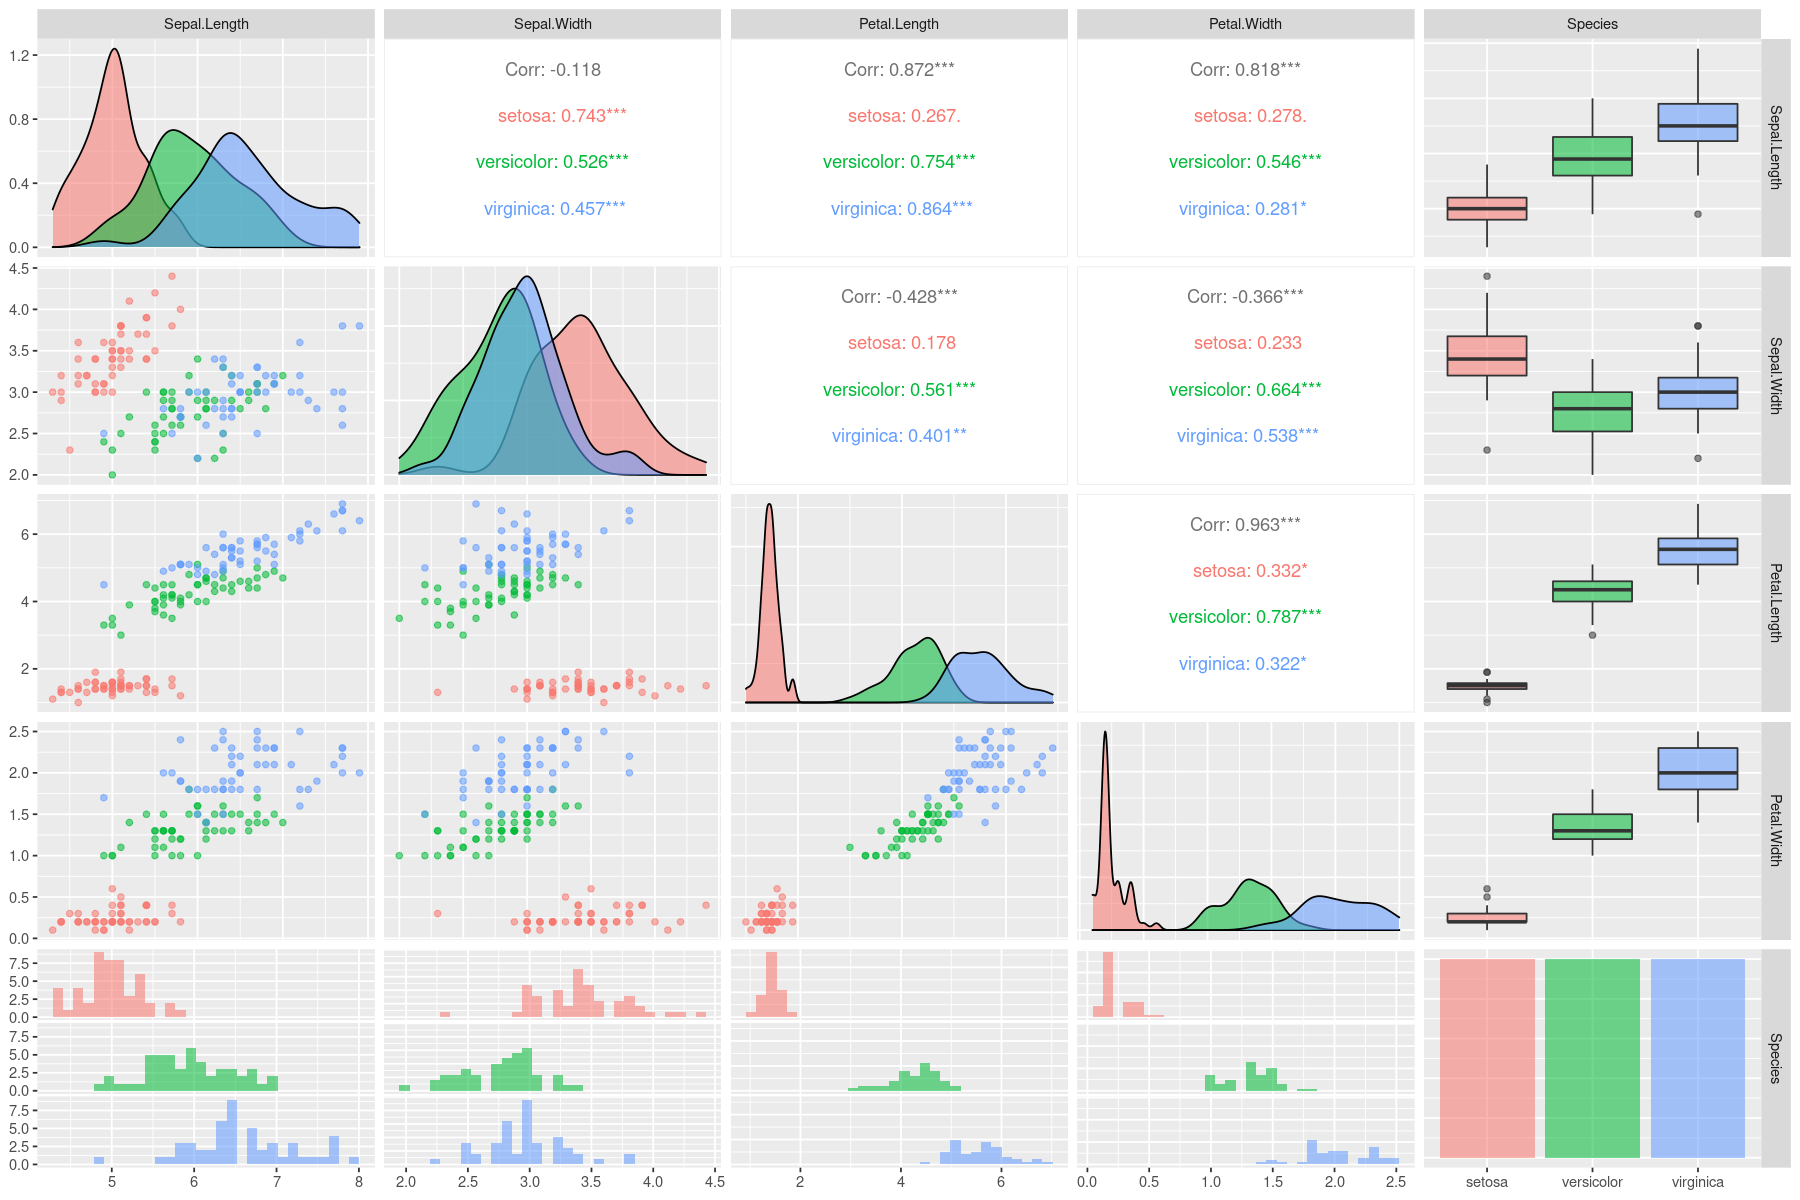

In [14]:
library(GGally)
options(repr.plot.width = 15, repr.plot.height=10)
ggpairs(iris, ggplot2::aes(col=Species, alpha=.2))

Petal.Length u setosa vypadá vcelku gaussovsky, můžeme zkusit ještě porovnat KDE ohad:

In [15]:
options(repr.plot.width = 10, repr.plot.height=5)
ggplot(irisSet, aes(x=Petal.Length)) + 
    geom_histogram(aes(y=..density..), colour = 1, fill = "white", bins=15) +
    geom_density(lwd=2, colour="blue", fill="lightblue", alpha=0.3) +
    stat_function(fun=dnorm, 
                  args=list(mean=mean(irisSet$Petal.Length), sd=sd(irisSet$Petal.Length)),
                  colour="red", lwd=2)

Můžeme zkusit normalitu i otestovat. Nejsilnějším z běžných testů je Shapirův-Wilkův test, ten má ovšem problémy, pokud se v datech objevuje mnoho stejných hodnot. Namísto něj proto sáhneme po jiném testu, např. [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) nebo [Kolmogorovově-Smirnovově](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). Více v příští přednášce.

In [16]:
jarque.test(irisSet$Petal.Length)
#ks.test(irisSet$Petal.Length, "pnorm", mean(irisSet$Petal.Length), sd(irisSet$Petal.Length))


	Jarque-Bera Normality Test

data:  irisSet$Petal.Length
JB = 1.4374, p-value = 0.4874
alternative hypothesis: greater


<font color="blue">**Nyní je čas udělat úkol 6.a - 6.d v druhém notebooku**</font>

---

### Korelační analýza

Jelikož máme více proměnných mezi nimiž může být nějaký (lineární či jiný) vztah, zkusíme udělat i korelační analýzu. Její výsledky nám napoví, zda by bylo možné veličiny vzájemně modelovat. To lze využít, mj. při doplňování chybějících dat.

In [17]:
R <- cor(iris[c(1:4)])
p1 <- corrplot(R, method="ellipse")    # methods: “circle”, “square”, “ellipse”, “number”, “shade”, “color”, “pie”.

Vzpomeňme, že test statistické významnosti lineárního korelačního koeficientu provedl již balík `GGally` výše.

<font color="blue">**Nyní je čas udělat úkol 7.a - 7.b v druhém notebooku**</font>

---